# Analyzing NYC High School Data

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline  

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

# reading in each csv file and storing in the dictionary called "data"

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
# correlation between sat_score and other fields
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting Correlations

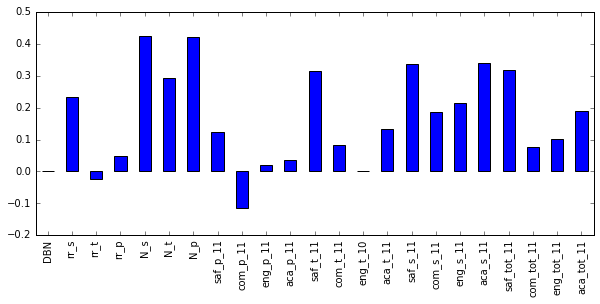

In [10]:
correlations[survey_fields].plot(kind="bar", figsize=(10,4))

There is a strong positive correlation between the number of parent respondents (N_p) and sat_score, which was surprising. 

## Safety and SAT Scores

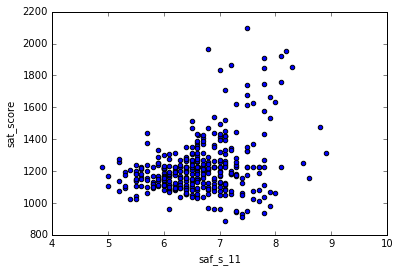

In [11]:
# scatter plot of Safety vs. SAT scores
combined.plot("saf_s_11", "sat_score", kind="scatter")
plt.show()

The perception of "safety" correlates highly with SAT scoresw--the higher the safety score, the higher the SAT score. 

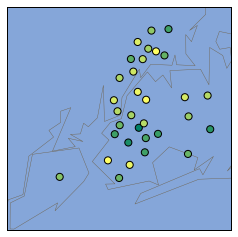

In [12]:
from mpl_toolkits.basemap import Basemap

# creating base map of NYC region

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index()

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

The lower part of The Bronx and Queens has higher safety scores, whereas middle Brooklyn has lower safety scores. 

## Race and SAT Scores

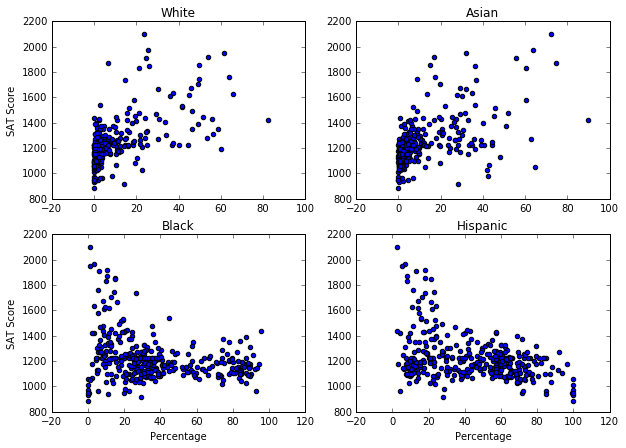

In [13]:
race_percentages = ["white_per","asian_per","black_per","hispanic_per"]
#correlations[race_percentages].plot.bar()
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(combined["white_per"], combined["sat_score"])
ax1.set_title("White")
ax1.set_ylabel("SAT Score")
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(combined["asian_per"], combined["sat_score"])
ax2.set_title("Asian")
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(combined["black_per"], combined["sat_score"])
ax3.set_title("Black")
ax3.set_xlabel("Percentage")
ax3.set_ylabel("SAT Score")
ax4 = fig.add_subplot(2,2,4)
ax4.scatter(combined["hispanic_per"], combined["sat_score"])
ax4.set_title("Hispanic")
ax4.set_xlabel("Percentage")
plt.show()

A high percentage of white or asian students correlates positively with SAT scores, while a higher percentage of black or hispanic students correlates negatively with SAT scores. 

In [19]:
hisp_95 = combined[combined["hispanic_per"] > 95]
hisp_95["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In schools where the hispanic population is greater than 95%, the schools seem to cater specifically to immigrant students. 

In [20]:
hisp_95 = combined[combined["hispanic_per"] < 10]
hisp_95["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

We can see above that for schools with less than 10% of the population being hispanic, they're not International schools. 

In [22]:
hisp_95 = combined[combined["hispanic_per"] < 10]
hisp_95 = hisp_95[hisp_95["sat_score"] > 1800]
hisp_95["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Gender And SAT Scores

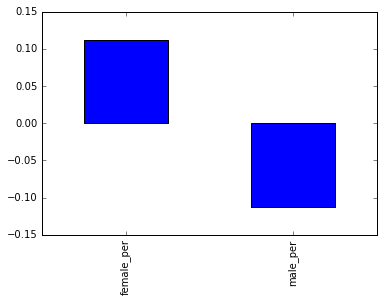

In [24]:
# correlation between sat_score and gender
corr_gender = correlations[["female_per", "male_per"]]

corr_gender.plot(kind="bar")

There's a positive correlation between female student percentage and SAT scores, while there is a negative correlation for male student percentage and SAT scores, albeit not strong correlations. 

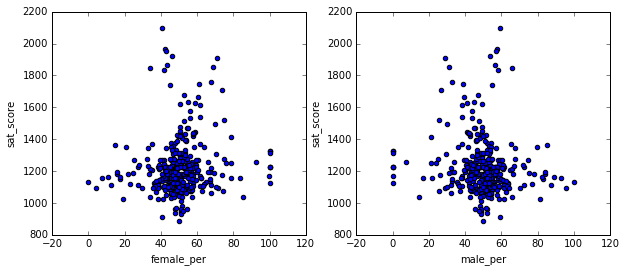

In [42]:
# plotting female percentage and male percentage versus SAT scores
genders = ["female_per","male_per"]

fig = plt.figure(figsize=(10,4))

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.scatter(combined[genders[i]], combined["sat_score"])
    ax.set_xlabel(genders[i])
    ax.set_ylabel("sat_score")
    
plt.show()

The scatterplot shows there is not a noticeable correlation between gender and SAT scores, which further reinforces our findings previously.

## AP Scores vs SAT Scores

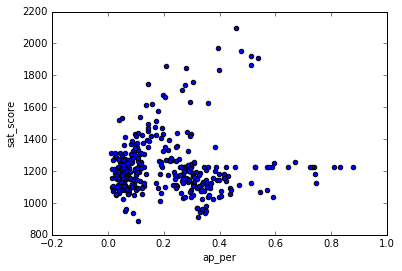

In [45]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot("ap_per", "sat_score", kind="scatter")